In [1]:
import lensing
from importlib import reload
reload(lensing)
from lensing import *
import matplotlib.pyplot as plt
from astropy.convolution import convolve, AiryDisk2DKernel, Gaussian2DKernel
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

In [2]:
x_deflections = open_fits('dplx.fits')
y_deflections = open_fits('dply.fits')
dx_header = fits.open('dplx.fits')[0].header

In [3]:
w = WCS(dx_header)
c = SkyCoord(ra=93.9795443, dec=-57.7723101, unit='deg',frame="fk5")
arc_center = w.world_to_pixel(c)
print(f"arc center pixel coordinates: {arc_center[0]}, {arc_center[1]}")

arc center pixel coordinates: 831.4647106641776, 2209.6455239446627


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [4]:
dx_header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 3000 / length of data axis 1                          
NAXIS2  =                 3000 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =                   0. / BZERO                                          
BSCALE  =                   1. / BSCALE                                         
EQUINOX =                2000. / EQUINOX                                        
RADECSYS= 'FK5     '           / RADECSYS                                       
CTYPE1  = 'RA---TAN'        

In [4]:
import astropy.units as u
w.proj_plane_pixel_scales()[0].to(u.arcsec)

<Quantity 0.04001334 arcsec>

In [4]:
deflections_grid = grid((0,0),3000,0.040013338)

## Convergence and Magnification

In [5]:
# lens redshift 0.972
magnification = magnification_from_deflections(deflections_grid, x_deflections, y_deflections, deflections_grid)
convergence = convergence_from_deflections(deflections_grid, x_deflections, y_deflections, deflections_grid)

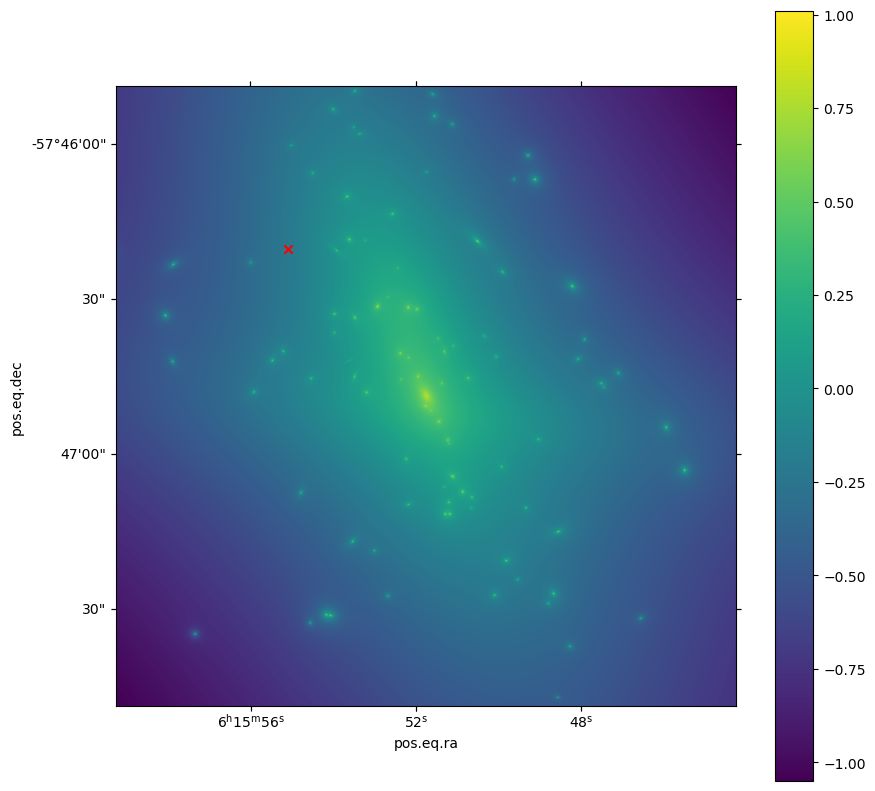

In [7]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=w)
ax.imshow(np.log10(np.flip(convergence,axis=0)))
ax.scatter(93.9795443,-57.7723101,marker='x',color='red',transform=plt.gca().get_transform('world'))
fig.colorbar(ax.images[0], ax=ax)

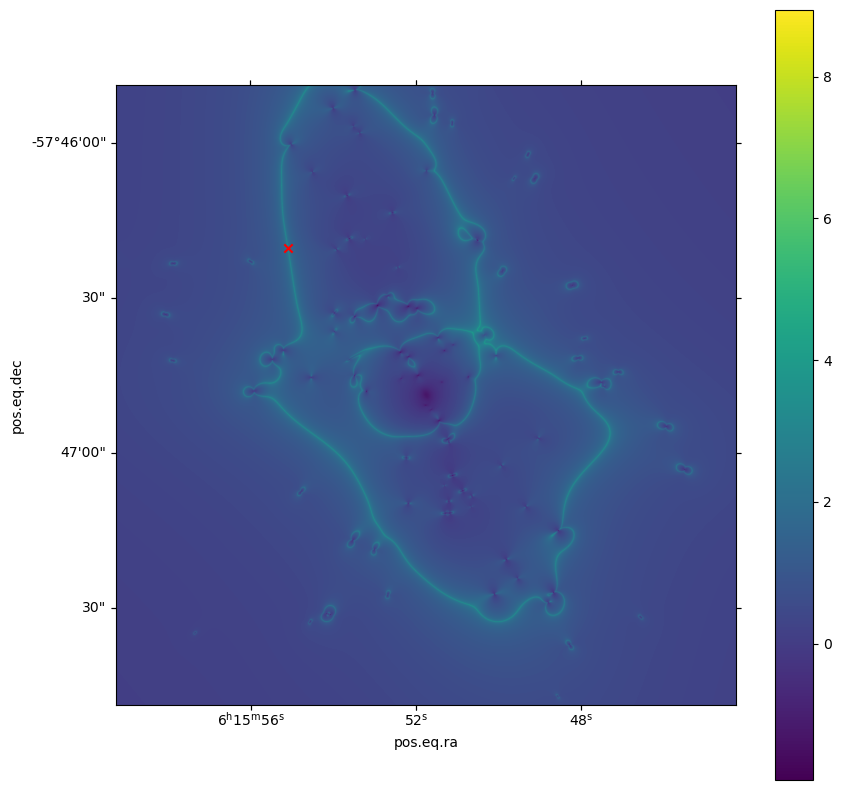

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=w)
ax.imshow(np.log10(np.flip(magnification,axis=0)))
ax.scatter(93.9795443,-57.7723101,marker='x',color='red',transform=plt.gca().get_transform('world'))
fig.colorbar(ax.images[0], ax=ax)

## Lensing

In [6]:
image_pixel_scale = 0.031
image_center = (-26.74,28.39)
#image_center = (24.85,-29.55)
image_pix = 1000
air_pix=0.05/image_pixel_scale

image_plane_corners = grid(image_center, image_pix+1, image_pixel_scale)
image_plane_centers = grid(image_center, image_pix, image_pixel_scale)
traced_image_plane_corners = ray_trace_grid(deflections_grid, x_deflections, y_deflections, image_plane_corners)
image_plane_magnification = magnification_line(deflections_grid, magnification,image_plane_centers)
caustic_line = caustic(deflections_grid, x_deflections, y_deflections, deflections_grid, magnification, image_plane_centers)

In [22]:
ray_trace_points(deflections_grid,x_deflections,y_deflections,np.array([[-26.74,28.39]]))

array([[ 1.29119469, 13.00406326]])

In [7]:
zoom = 4
galaxy_image = open_fits("new2.fits")
galaxy_image = galaxy_image*zoom
source_pixel_scale = 0.0001*zoom
source_center = (1.29119469, 13.00406326)
source_pix = 1000
source_plane = grid(source_center, source_pix, source_pixel_scale)

In [8]:
galaxy_center = (-0.02,-0.02)
galaxy_angle = -70

transformed_galaxy = transform_image(galaxy_image, galaxy_angle, galaxy_center, source_pixel_scale)
lensed_image = lens_image(transformed_galaxy, source_plane, traced_image_plane_corners)
lensed_image = convolve(lensed_image, Gaussian2DKernel(2.065/2.355))
#lensed_image = convolve(lensed_image, AiryDisk2DKernel(2.5),fill_value=0,nan_treatment='fill')
lensed_image = lensed_image + np.random.normal(5e-9,3e-10,(image_pix,image_pix))
# hdu = fits.PrimaryHDU(np.flip(transformed_galaxy,axis=0))
# hdu.writeto('new_galaxy.fits')

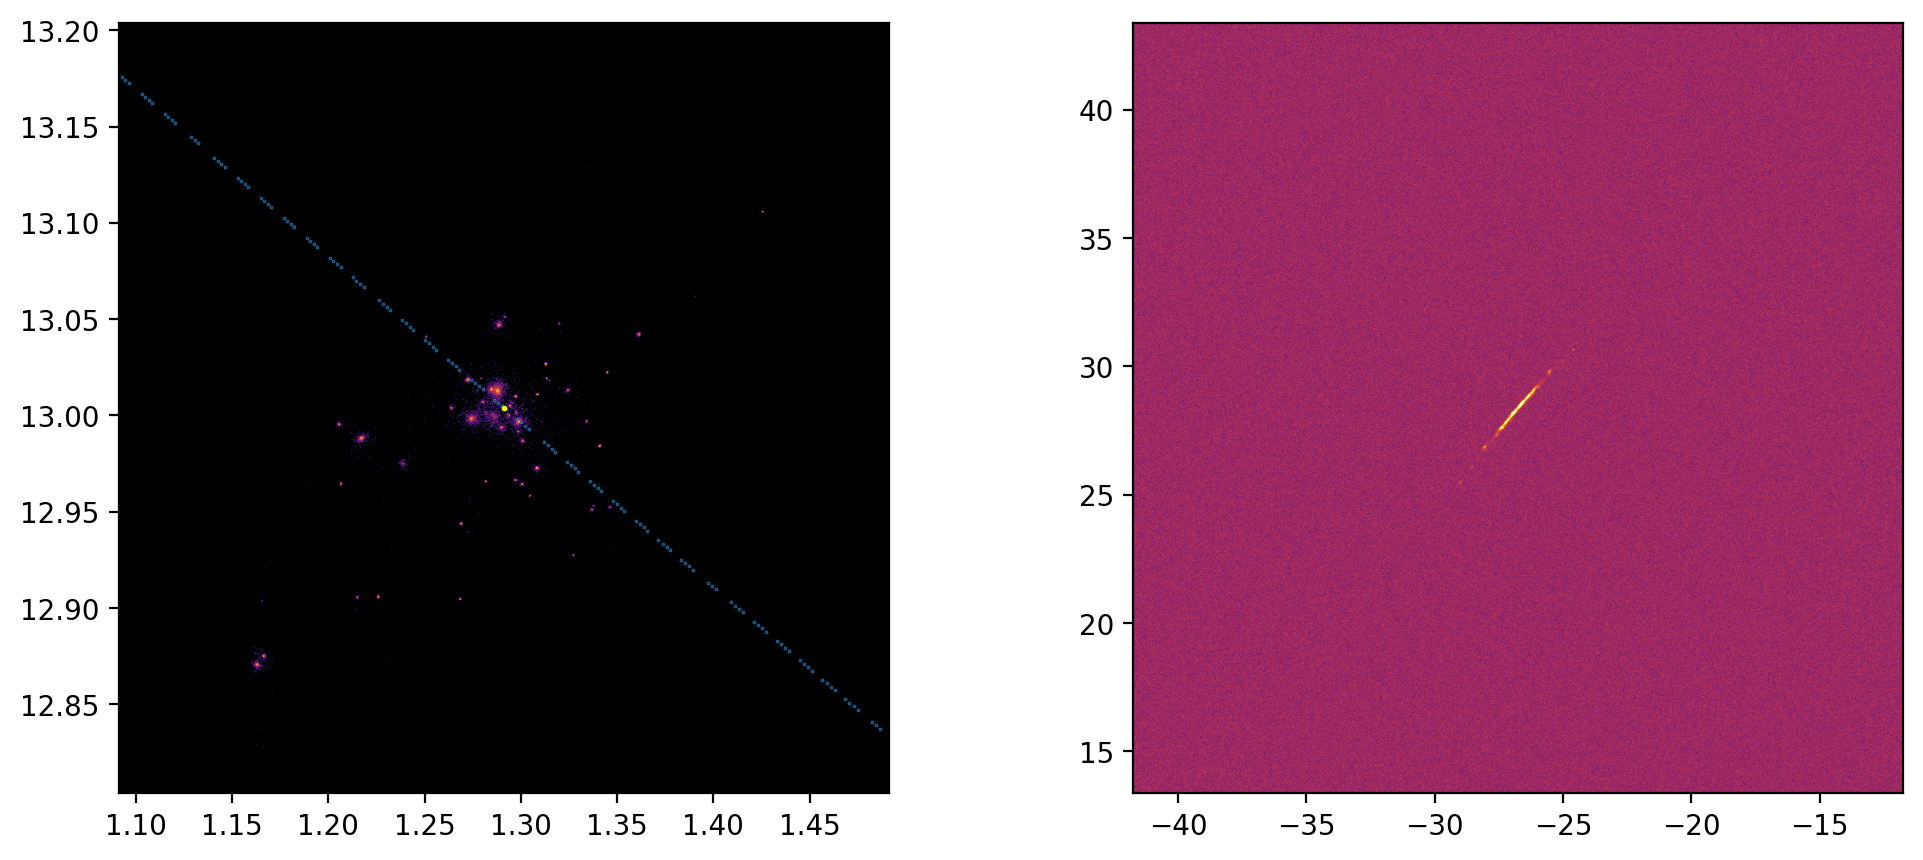

In [9]:
from matplotlib.colors import LogNorm

# plot source image
extent = [source_center[0]-0.05*zoom,source_center[0]+0.05*zoom,source_center[1]-0.05*zoom,source_center[1]+0.05*zoom]
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=200)
ax[0].scatter(caustic_line[:,0],caustic_line[:,1],s=0.1)
ax[0].set_xlim(extent[:2])
ax[0].set_ylim(extent[2:])
ax[0].scatter(source_center[0],source_center[1],s=1,c="yellow")
ax[0].imshow(transformed_galaxy, extent=extent, cmap='inferno',norm=LogNorm())
ax[0].set_facecolor('black')

#ax[1].scatter(image_plane_magnification[:,0], image_plane_magnification[:,1], s=0.01)
ax[1].imshow(lensed_image, extent=[image_center[0]-15,image_center[0]+15,image_center[1]-15,image_center[1]+15], cmap='inferno',norm=LogNorm(vmin=3e-9,vmax=1e-8))
ax[1].set_facecolor('black')
plt.show()

In [35]:
wcs = WCS(naxis=2)
wcs.wcs.crpix = [1001/2,1001/2]
wcs.wcs.cdelt = [-0.031/3600,0.031/3600]
wcs.wcs.crval = np.array([93.9795443, -57.7723101])
wcs.wcs.ctype = ["RA---TAN","DEC--TAN"]

hdu = fits.PrimaryHDU(np.flip(lensed_image*1e8,axis=0))
hdu.header.update(wcs.to_header())
hdu.writeto('spt1.fits',overwrite=True)

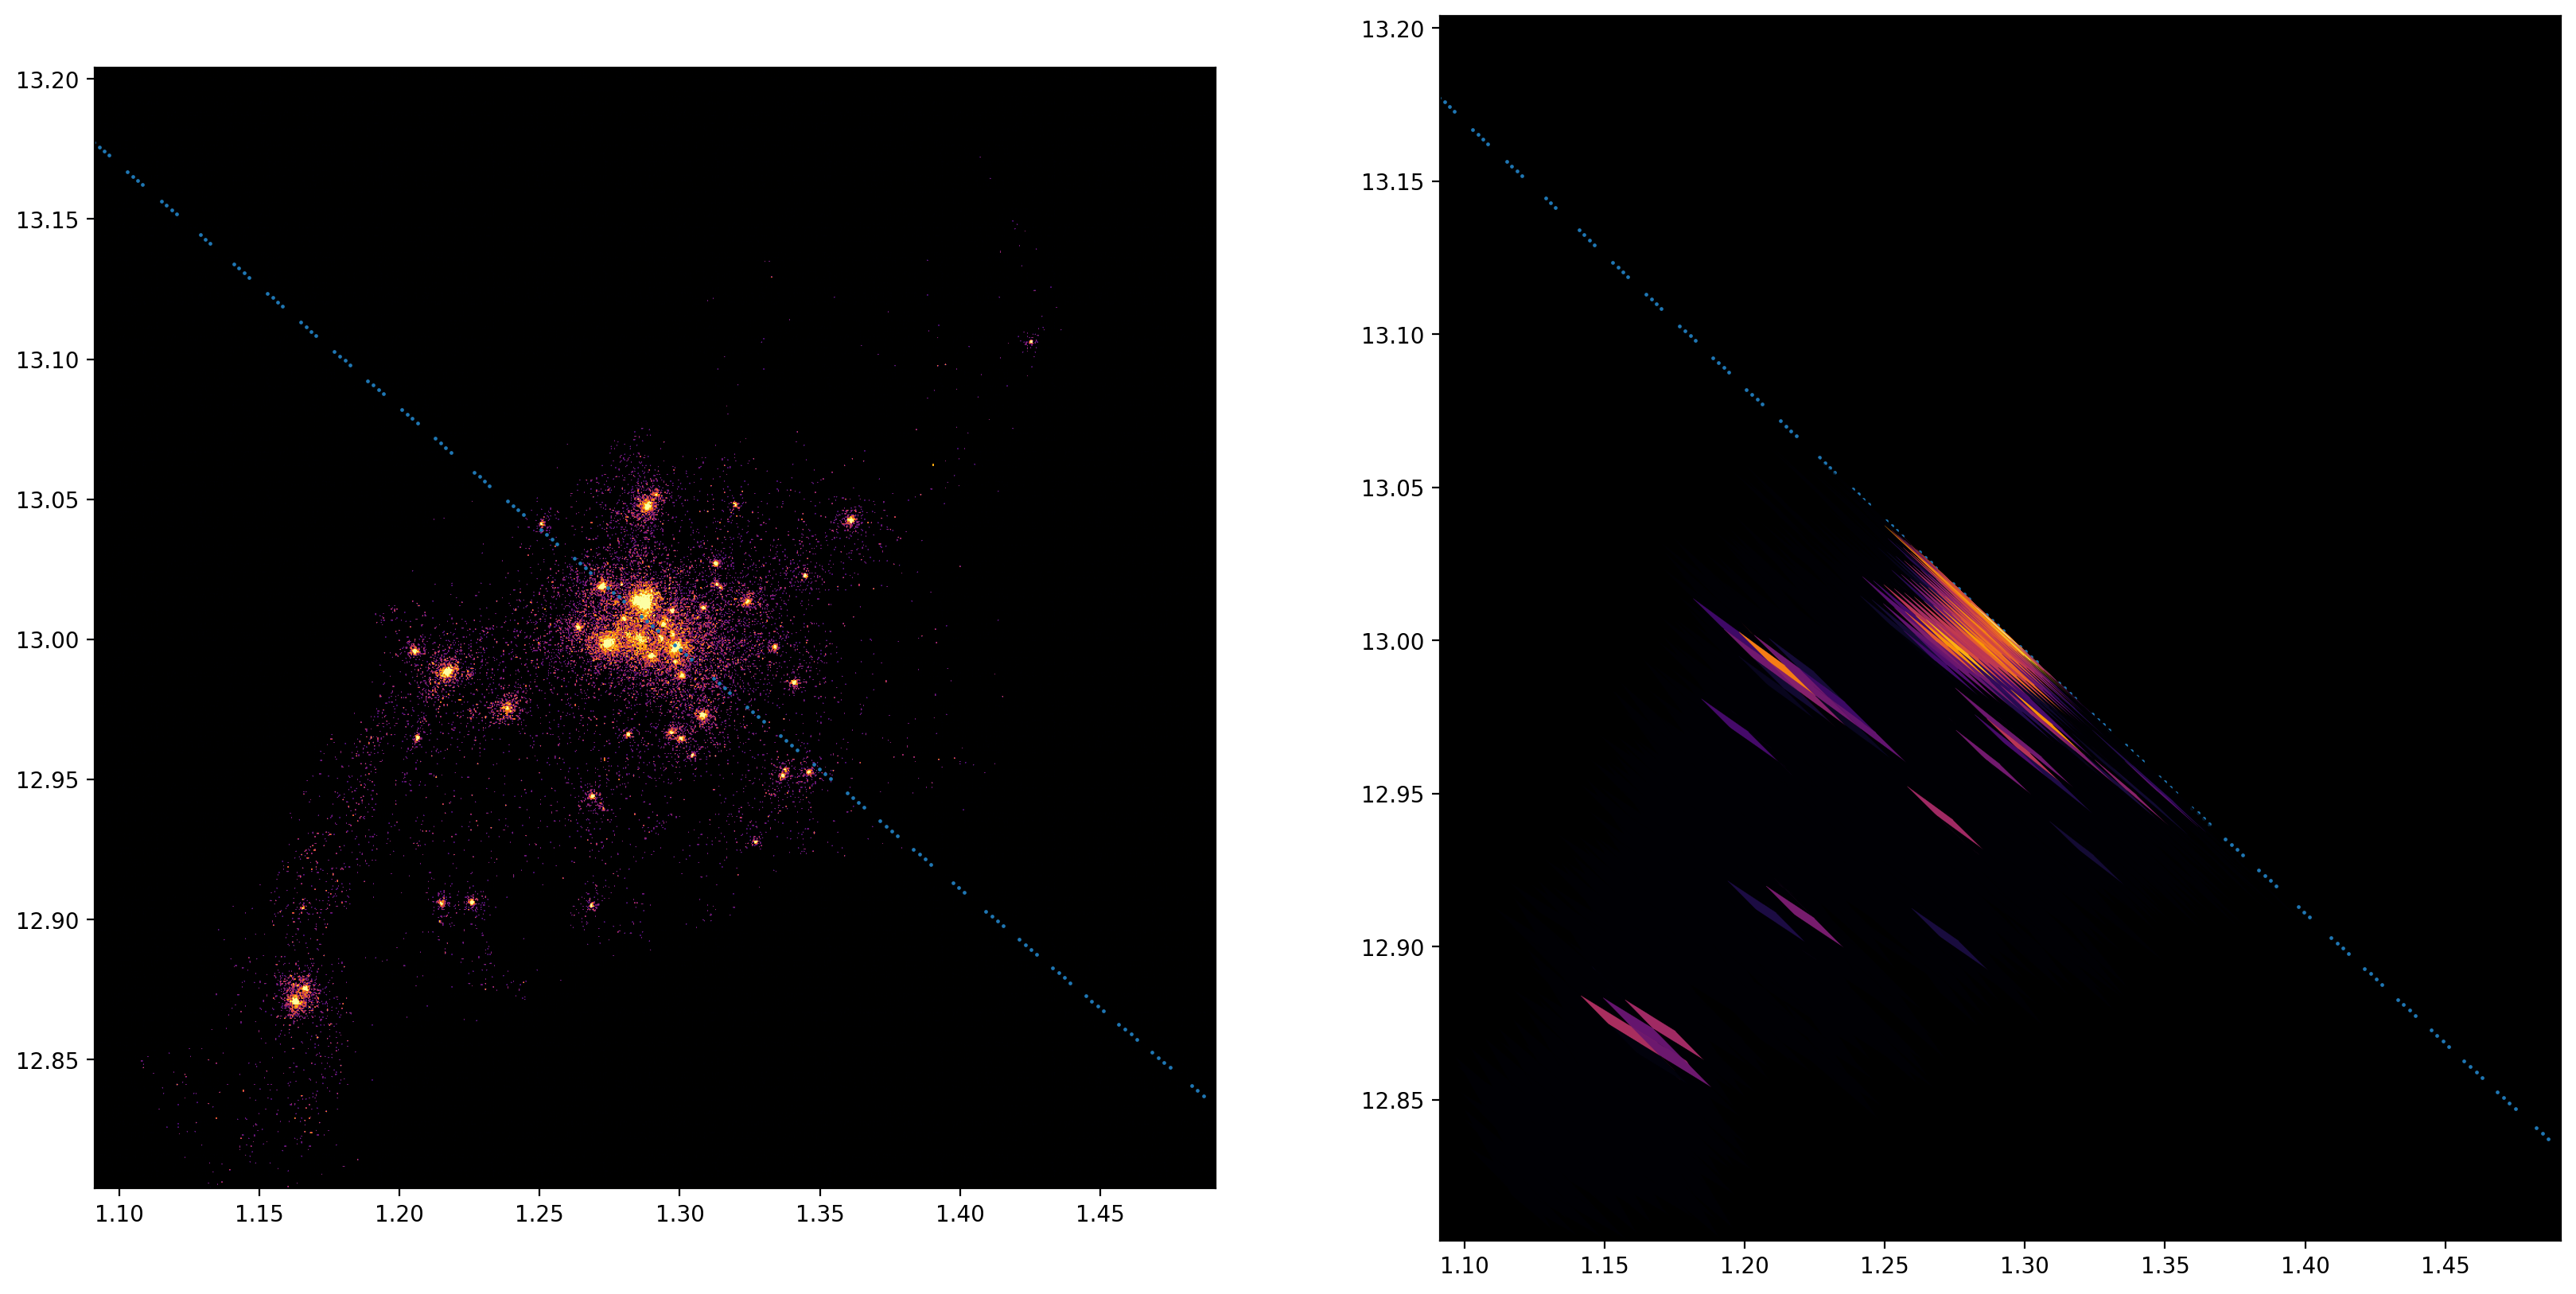

In [43]:
from matplotlib.patches import Polygon
import matplotlib as mpl

fig, ax = plt.subplots(1,2,figsize=(20,10),dpi=200)
cmap = mpl.colormaps['inferno']

lums = get_traced_luminosities(transformed_galaxy, source_plane, traced_image_plane_corners)
norm = LogNorm(vmin=1e-9,vmax=3e-8)

ax[0].imshow(transformed_galaxy, extent=extent, cmap='inferno',norm=norm)

polygons = get_traced_pixels(source_plane,traced_image_plane_corners)
polygons = polygons[lums != 0]
lums = lums[lums != 0]
polygons = [Polygon(p,closed=True,fill=True,color=cmap(norm(lums[i])),lw=0.1) for i,p in enumerate(polygons)]
ax[0].set_xlim(extent[:2])
ax[0].set_ylim(extent[2:])
ax[1].set_xlim(extent[:2])
ax[1].set_ylim(extent[2:])
ax[0].scatter(caustic_line[:,0],caustic_line[:,1],s=0.5)
ax[1].scatter(caustic_line[:,0],caustic_line[:,1],s=0.5)
#ax[1].scatter(source_center[0],source_center[1],s=1,c="yellow")
ax[0].set_facecolor('black')
ax[1].set_facecolor('black')
for i,p in enumerate(polygons):
    ax[1].add_patch(p)

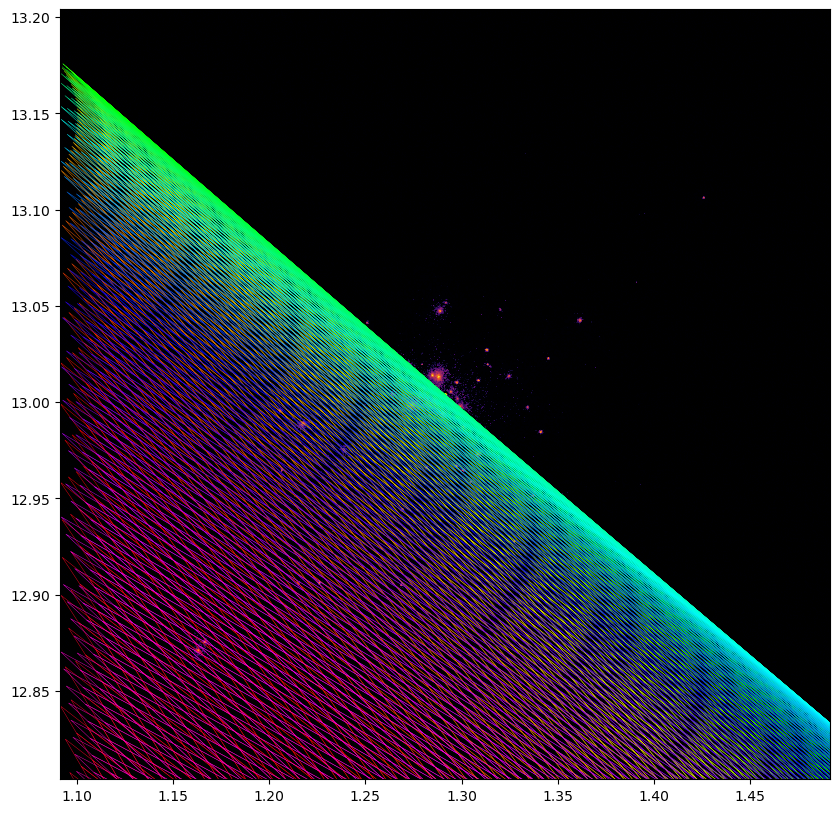

In [37]:
import matplotlib as mpl
from matplotlib.patches import Polygon

cmap = mpl.colormaps['gist_rainbow']
scale = 1
downsampled_image_plane_corners = grid(image_center, int(image_pix/scale), image_pixel_scale*scale)
downsampled_traced_image_plane_corners = ray_trace_grid(deflections_grid, x_deflections, y_deflections, downsampled_image_plane_corners)
fig, ax = plt.subplots(1,1,figsize=(10,10))
polygons = get_traced_pixels(source_plane,downsampled_traced_image_plane_corners)
num_polygons = len(polygons)
polygons = [Polygon(p,closed=True,fill=False,color=cmap(i/num_polygons),lw=0.3) for i,p in enumerate(polygons)]
ax.set_xlim(extent[:2])
ax.set_ylim(extent[2:])
# ax.set_xlim(0.15,0.2)
# ax.set_ylim(-7.7,-7.65)
ax.scatter(source_center[0],source_center[1],s=1,c="yellow")
ax.imshow(transformed_galaxy, extent=extent, cmap='inferno',norm=LogNorm())
ax.set_facecolor('black')
for i,p in enumerate(polygons):
    ax.add_patch(p)

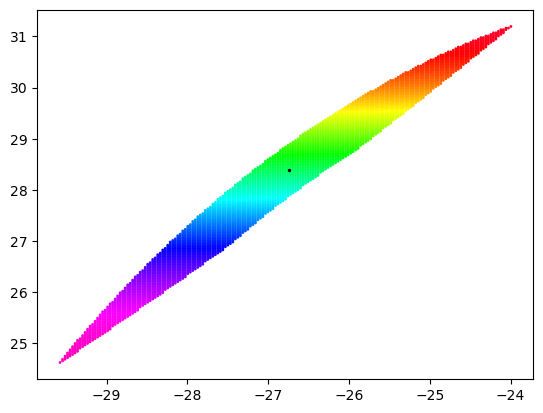

In [38]:
arc_points = get_arc_pixels(source_plane,downsampled_traced_image_plane_corners,downsampled_image_plane_corners)
colors = np.array([cmap(i/num_polygons) for i in range(num_polygons)])
plt.scatter(arc_points[:,0],arc_points[:,1],c=colors,s=1)
plt.scatter(-26.74,28.39,color="black",s=2) # plot earendel